# Economicos

In [1]:
%%capture
import sys
!ln -s ../syntheticml .
!{sys.executable} -m pip install -U -r ../requirements.txt
!{sys.executable} -m pip install -U kaleido

In [2]:
import pandas as pd
import numpy as np
df = pd.read_parquet('../datasets/economicos/raw/full_dedup_economicos_step0.parquet');
df.sample(3)

,url,description,price,property_type,transaction_type,state,county,publication_date,rooms,bathrooms,m_built,m_size,source,title,address,owner,_price
473494,https://www.economicos.cl/propiedades/departam...,"640.000 costado Parque Arauco, 3 dormitorios, ...",$ 640.000,Departamento,Arriendo,None,Las Condes,2019-07-27 00:00:00,3.0,2.0,NaN,NaN,El Mercurio,Departamento en Arriendo en Las Condes 3 dormi...,"Las Condes,",,22.895231
581271,https://www.economicos.cl/propiedades/oficina-...,Kazona Propiedades arrienda Excelentes oficina...,65 UF,Oficina o Casa Oficina,Venta,Metropolitana de Santiago,Providencia,2022-02-23 22:08:00,6.0,NaN,325.0,325.0,El Mercurio,Oficina o Casa Oficina en Venta en Providencia...,GRAN OFICINA EN EXCELENTE SECTOR DE PROVIDENCI...,Gestión y Propiedad,65.000000
122831,https://www.economicos.cl/propiedades/estacion...,Arriendo estacionamiento subterráneo .\nmensu...,$ 70.000,Estacionamiento,Arriendo,Metropolitana de Santiago,Santiago,2018-05-05 22:32:19,NaN,NaN,NaN,NaN,None,None,None,None,2.591284


In [3]:
%%capture
from syntheticml.data.synthetic import Synthetic, MODELS
category_columns=("property_type", "transaction_type", "state", "county", "rooms", "bathrooms", "m_built", "m_size", )
# TODO: Estudiar implicancia de valores nulos en categorias y numeros
df_converted = df.fillna(dict(
        property_type = "None",
        transaction_type = "None",
        state = "None",
        county = "None",
        rooms = -1,
        bathrooms = -1,
        m_built = -1,
        m_size = -1,
        source = "None"
)).fillna(-1).astype({k: 'str' for k in ("description", "price", "title", "address", "owner",)})
df_converted = df.replace(to_replace="None", value=np.nan).replace(to_replace=-1, value=np.nan).dropna().astype({k: 'str' for k in ("description", "price", "title", "address", "owner",)})

syn = Synthetic(df_converted, 
        id="url", 
        category_columns=category_columns,
        text_columns=("description", "price", "title", "address", "owner", ),
        exclude_columns=("publication_date", "source", ),
        synthetic_folder = "../datasets/economicos/synth",
        models=['copulagan', 'tvae', 'gaussiancopula', 'ctgan', 'smote-enc', 'tddpm_mlp'],
        n_sample = df.shape[0],
        target_column="_price",
        max_cpu_pool=1
)


In [4]:
%%capture
syn.process()
#syn.process(remaining_columns=("property_type", "transaction_type", "state",))
syn.process_scores()


## Metricas
### Continuas

In [5]:
metrics = syn.current_metrics()
metrics[~metrics.is_categorical].dropna(axis=1, how='all')

,name,top5,top5_freq,top5_prob,is_categorical,nobs,missing,mean,std_err,upper_ci,...,mode_freq,median,0.1%,1.0%,5.0%,25.0%,75.0%,95.0%,99.0%,99.9%
2,_price,"[0.0, 3500.0, 5500.0, 6500.0, 4500.0]","[17989, 865, 767, 763, 740]","[0.03295473281184165, 0.001584626376243428, 0....",False,545870.0,0.0,7.098298e+09,7.021735e+09,2.086065e+10,...,0.032955,174.02451,0.0,0.0,1.26969,12.28306,3550.0,14400.0,47000.0,1.906676e+06


### Categoricas

In [6]:
metrics[metrics.is_categorical].dropna(axis=1, how='all')

,name,top5,top5_freq,top5_prob,is_categorical,nobs,missing
0,county,"[Santiago, Viña del Mar, Las Condes, Providenc...","[65125, 33263, 32327, 27981, 24863]","[0.11930496272006155, 0.06093575393408687, 0.0...",True,545870.0,545870.0
1,transaction_type,"[Venta, Arriendo, Busco arriendo, Compro, None]","[282495, 258300, 3031, 1901, 86]","[0.5175133273490025, 0.473189587264367, 0.0055...",True,545870.0,545870.0
3,m_size,"[-1.0, 5000.0, 200.0, 60.0, 50.0]","[245062, 19573, 6932, 6312, 5748]","[0.44893839192481727, 0.0358565226152747, 0.01...",True,545870.0,545870.0
4,state,"[Metropolitana de Santiago, Valparaíso, Biobío...","[272808, 108197, 29379, 21581, 16533]","[0.49976734387308336, 0.1982101965669482, 0.05...",True,545870.0,545870.0
5,bathrooms,"[-1.0, 2.0, 1.0, 3.0, 4.0]","[206916, 136581, 134963, 43884, 14719]","[0.3790572847014857, 0.2502079249638192, 0.247...",True,545870.0,545870.0
6,property_type,"[Departamento, Casa, Sitio o Terreno, Parcela ...","[211405, 142054, 31393, 30020, 27415]","[0.38728085441588656, 0.26023412167732246, 0.0...",True,545870.0,545870.0
7,rooms,"[-1.0, 3.0, 2.0, 1.0, 4.0]","[196417, 125902, 97220, 54183, 44539]","[0.35982376756370565, 0.23064465898473996, 0.1...",True,545870.0,545870.0
8,m_built,"[-1.0, 60.0, 50.0, 70.0, 100.0]","[188514, 13831, 11796, 11648, 9716]","[0.3453459614926631, 0.025337534577829886, 0.0...",True,545870.0,545870.0


## Scores

In [12]:
#best_model = "smote-enc_noise_682338"
best_model = "tddpm_mlp_noise_682338"
avg = syn.scores[syn.scores["type"] == "avg"]
avg.sort_values("score", ascending=False)[["score", "DCR ST 5th", "DCR SH 5th", "DCR TH 5th"]]

,score,DCR ST 5th,DCR SH 5th,DCR TH 5th
name,,,,
tddpm_mlp_noise_682338,9.396880e-01,0.000000e+00,0.000000e+00,0.0
smote-enc_noise_682338,8.942758e-01,0.000000e+00,0.000000e+00,0.0
smote-enc_682338,8.937847e-01,0.000000e+00,0.000000e+00,0.0
ctgan_682338,7.096091e-01,0.000000e+00,0.000000e+00,0.0
tvae_682338,7.019431e-01,0.000000e+00,0.000000e+00,0.0
ctgan_noise_682338,6.578982e-01,0.000000e+00,0.000000e+00,0.0
tvae_noise_682338,6.556435e-01,0.000000e+00,0.000000e+00,0.0
tddpm_mlp_682338,5.524601e-01,0.000000e+00,0.000000e+00,0.0
gaussiancopula_682338,5.301658e-01,7.986155e-05,3.201748e-05,0.0


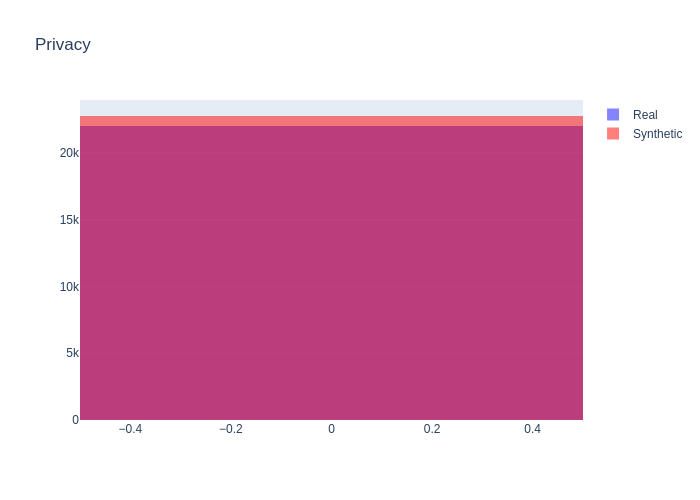

None

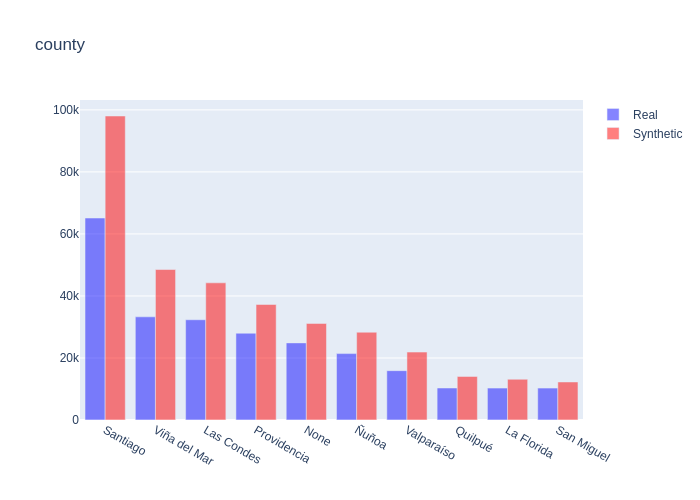

None

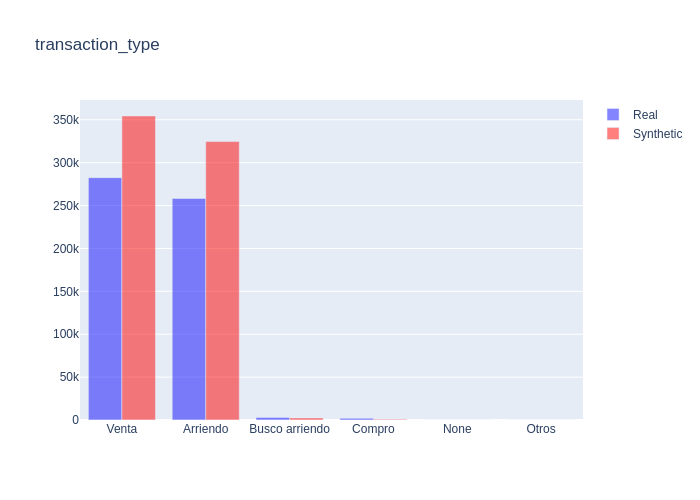

None

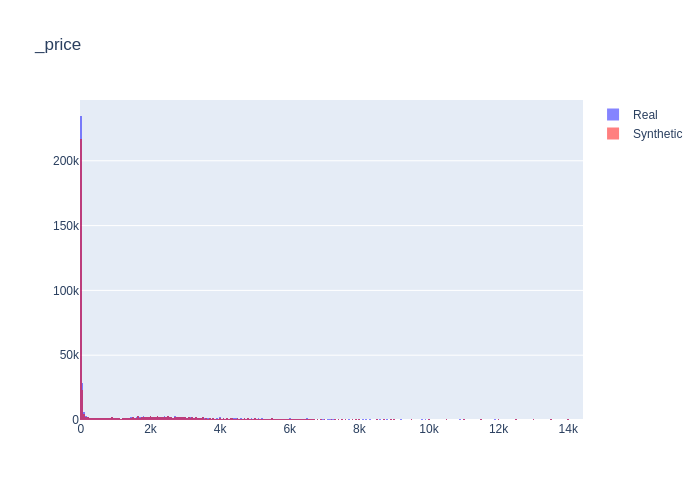

None

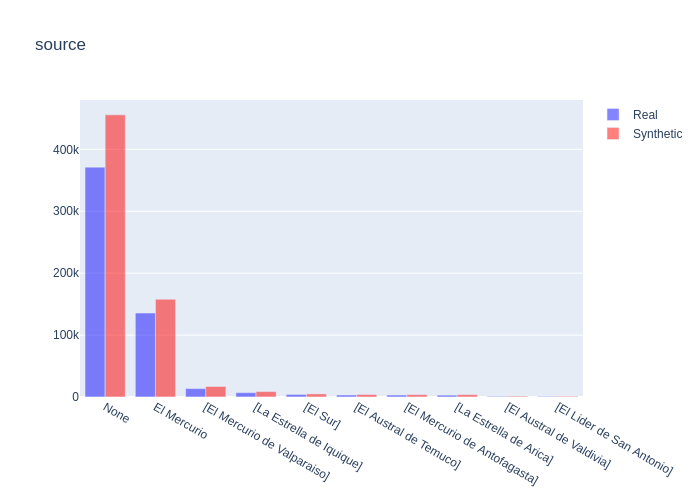

None

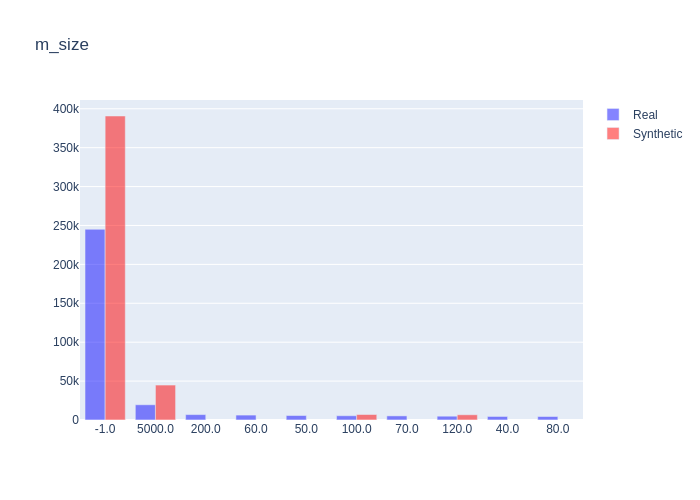

None

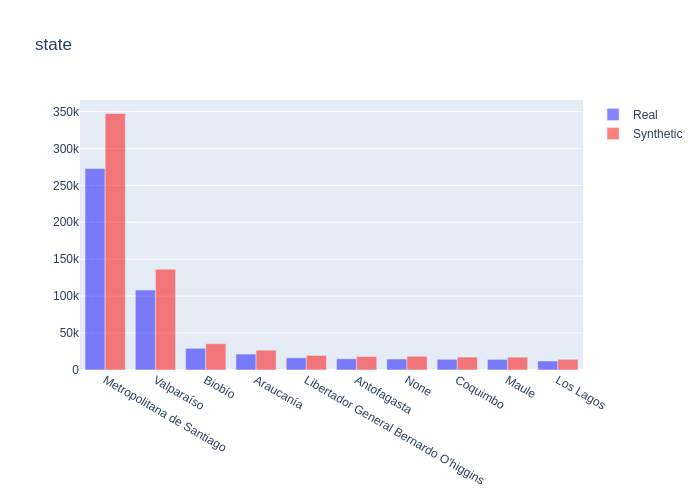

None

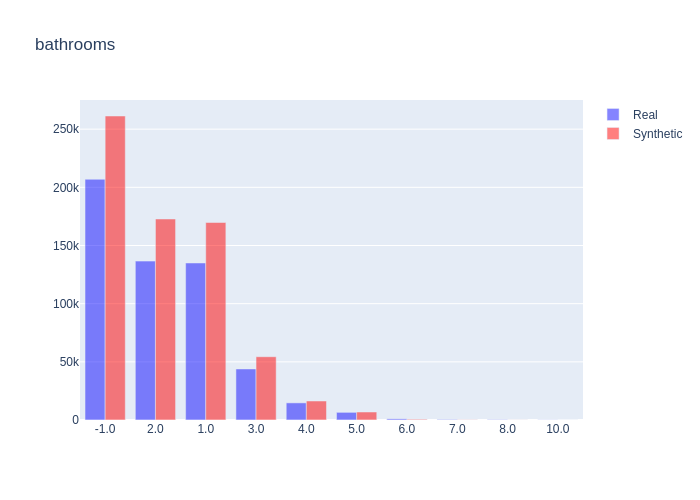

None

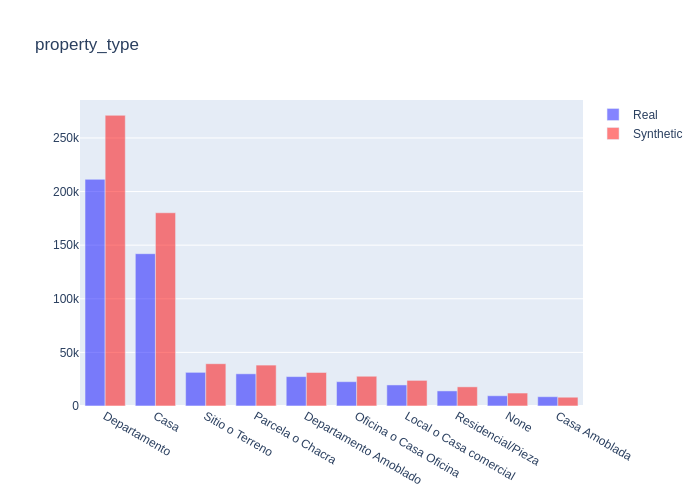

None

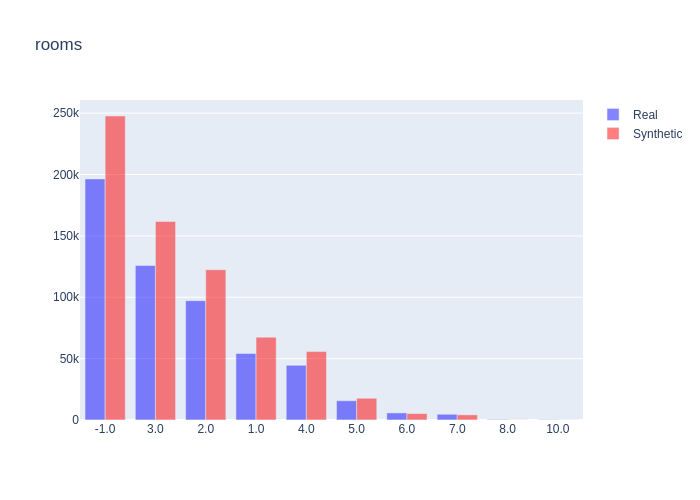

None

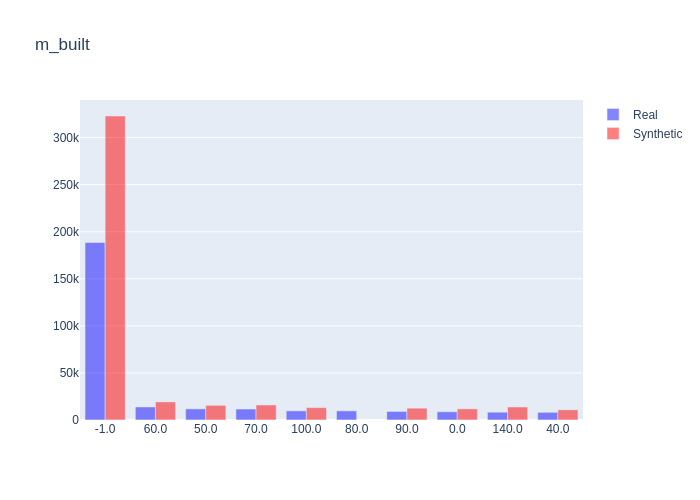

None

In [8]:
from syntheticml.data.charts import Charts
for fig in syn.get_charts(best_model, {'date', 'id', 'zipcode', 'lat', 'long', 'yr_renovated'}):
    if fig:
        display(fig.show("png"))

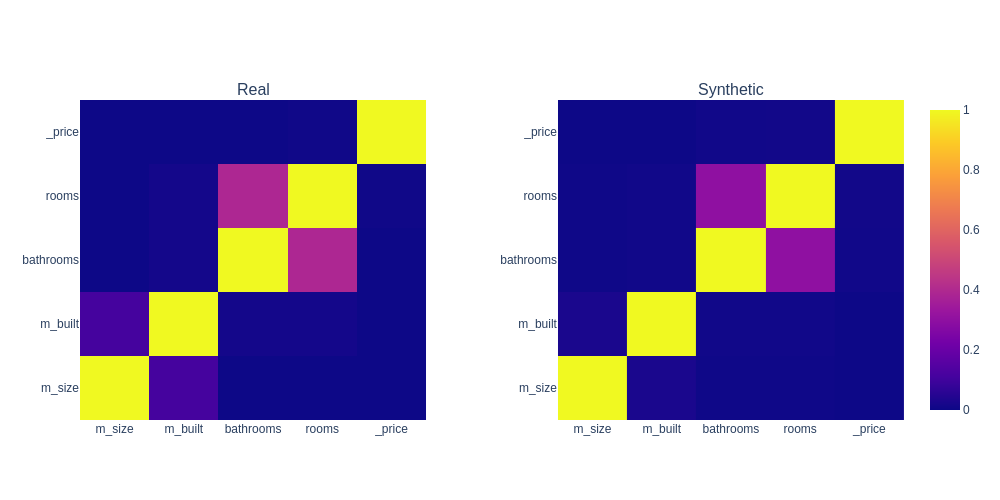

In [13]:
syn.charts.pair_corr(df.loc[:, syn.fake_data[best_model].columns].dropna(), syn.fake_data[best_model].astype({k:np.float64 for k in ('bathrooms','rooms','m_built','m_size')}), {'id', 'waterfront', 'yr_renovated'}, "_price").update_layout(dict(width=1000)).show("png")

In [10]:
syn.fake_data[best_model]

,url,_price,property_type,transaction_type,state,county,rooms,bathrooms,m_built,m_size,source
0,0,8.163292,Departamento,Arriendo,Metropolitana de Santiago,Santiago,1.0,-1.0,-1.0,-1.0,El Mercurio
1,1,19.950323,Departamento,Arriendo,Metropolitana de Santiago,Ñuñoa,3.0,2.0,80.2,80.68,None
2,2,0.000000,Casa,Venta,Antofagasta,None,-1.0,-1.0,-1.0,-1.0,"[El Mercurio de Calama, La Estrella del Loa]"
3,3,18.391346,Departamento,Arriendo,Metropolitana de Santiago,Providencia,2.0,2.0,70.0,-1.0,None
4,4,19.188005,Casa,Arriendo,Metropolitana de Santiago,Ñuñoa,3.0,2.0,-1.0,-1.0,None
...,...,...,...,...,...,...,...,...,...,...,...
682333,32333,1813.844437,Departamento,Venta,Metropolitana de Santiago,Quinta Normal,3.0,1.0,-1.0,-1.0,None
682334,32334,2150.785599,Departamento,Venta,Metropolitana de Santiago,Las Condes,1.0,-1.0,-1.0,-1.0,El Mercurio
682335,32335,5415.931108,Local o Casa comercial,Venta,Metropolitana de Santiago,La Reina,-1.0,-1.0,180.0,20.85,None
682336,32336,312.704179,Casa,Venta,Valparaíso,Viña del Mar,-1.0,-1.0,-1.0,-1.0,El Mercurio


In [11]:
syn.df

,url,description,price,property_type,transaction_type,state,county,publication_date,rooms,bathrooms,m_built,m_size,source,title,address,owner,_price
0,https://www.economicos.cl/propiedades/propieda...,Se ofrece estacionamiento en general jofre 180,$ 75.000,Estacionamiento,Arriendo,Metropolitana de Santiago,Santiago,2019-09-12 10:52:13,-1.0,-1.0,-1.0,-1.0,None,-1,-1,-1,2.677144
1,https://www.economicos.cl/propiedades/se-vende...,"Se vende hermosa casa camino a Puente Negro, a...",9595 UF,Casa,Venta,Libertador General Bernardo O'higgins,San Fernando,2019-09-12 10:50:25,6.0,5.0,317.0,5290.0,None,-1,-1,-1,9595.000000
2,https://www.economicos.cl/propiedades/propieda...,Se ofrece hermosa oficina en el corazón de Ñ...,$ 280.000,Oficina o Casa Oficina,Arriendo,Metropolitana de Santiago,Ñuñoa,2019-09-12 10:48:56,-1.0,-1.0,27.0,27.0,None,-1,-1,-1,9.994671
3,https://www.economicos.cl/propiedades/derecho-...,EXCELENTE OPORTUNIDAD!! Se vende Derecho llave...,$ 29.990.000,Negocio/Patentes/Derechos de llave,Venta,Metropolitana de Santiago,Providencia,2019-09-12 10:48:55,-1.0,-1.0,50.0,50.0,None,-1,-1,-1,1070.500634
4,https://www.economicos.cl/propiedades/estacion...,Ubicado en Calle Mujica 55 / 99\nSubterráneo....,$ 55.000,Estacionamiento,Arriendo,Metropolitana de Santiago,Ñuñoa,2019-09-12 10:47:25,-1.0,-1.0,13.0,13.0,None,-1,-1,-1,1.963239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760002,https://www.economicos.cl/propiedades/oficina-...,320.000 Urrutia Propiedades Pérez Valenzuela ...,$ 320.000,Oficina o Casa Oficina,Arriendo,Metropolitana de Santiago,Providencia,2020-10-17 00:06:00,-1.0,-1.0,-1.0,-1.0,El Mercurio,Oficina o Casa Oficina en Arriendo en Providencia,"Providencia, Metropolitana de Santiago",,11.126244
760004,https://www.economicos.cl/propiedades/departam...,"350.000 Quinta Normal Departamento, excelente ...",$ 350.000,Departamento,Arriendo,Metropolitana de Santiago,Quinta Normal,2020-10-17 00:06:00,-1.0,-1.0,-1.0,-1.0,El Mercurio,Departamento en Arriendo en Quinta Normal,"Quinta Normal, Metropolitana de Santiago",,12.169329
760006,https://www.economicos.cl/propiedades/departam...,230.000 Tucapel Jiménez/ Cercano a Metro Mone...,$ 230.000,Departamento,Arriendo,Metropolitana de Santiago,Santiago,2020-10-17 00:06:00,1.0,-1.0,-1.0,-1.0,El Mercurio,Departamento en Arriendo en Santiago 1 dormitorio,"Santiago, Metropolitana de Santiago",,7.996988
760007,https://www.economicos.cl/propiedades/oficina-...,350000 providencia / seminario 3 privados rece...,$ 350.000,Oficina o Casa Oficina,Arriendo,Metropolitana de Santiago,Providencia,2020-10-17 00:06:00,-1.0,-1.0,-1.0,-1.0,El Mercurio,Oficina o Casa Oficina en Arriendo en Providencia,"Providencia, Metropolitana de Santiago",,12.169329
